In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pymc as pm
import arviz as az

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# 1)
Estamos interesados en la proporción de éxito 𝜃 de una distribución Bernoulli. Tenemos una
muestra observada que consiste en el número de éxitos en 30 ensayos independientes y con idéntica distribución de una Bernoulli con parámetro 𝜃; en esta muestra hay precisamente 19 éxitos.

## a)
Suponiendo una prior uniforme sobre 𝜃, calcular la distribución posterior y graficarla. ¿Cuál
es el 90% HPDI?


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]


Output()

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 20 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


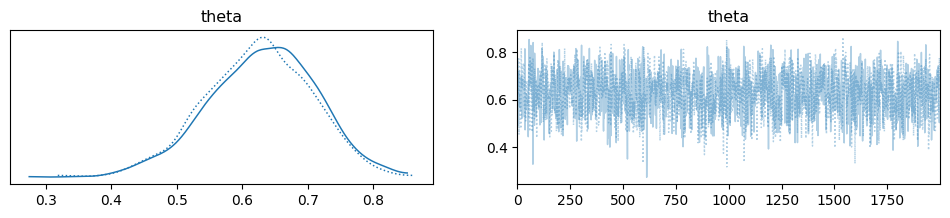

In [2]:

n = 30
k = 19

with pm.Model() as model:
    # prior uniforme
    theta = pm.Uniform('theta', 0, 1)
    # likelihood binomial
    likelihood = pm.Binomial('likelihood', n=n, p=theta, observed=k)
    # posterior
    trace = pm.sample(2000)

az.plot_trace(trace)
plt.show()

<Axes: title={'center': 'theta'}>

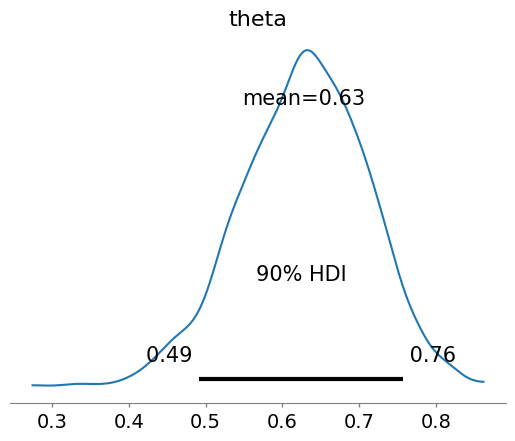

In [3]:
az.plot_posterior(trace, hdi_prob=0.90)

## b)
Calcular para cada 𝑘 la probabilidad de obtener 𝑘 éxitos en 10 experimentos con la posterior
predictive. ¿Se trata ésta de una distribución binomial?

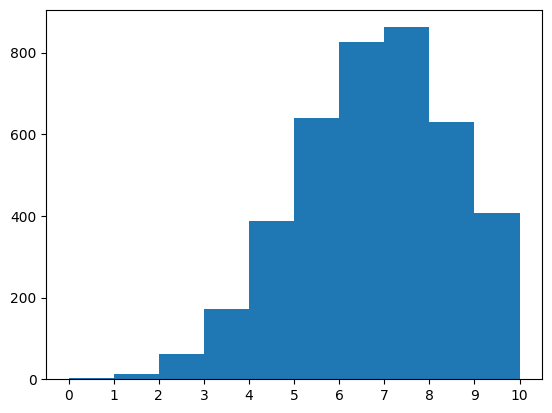

In [3]:
experimentos = 10

theta_samples = trace.posterior['theta'].values.flatten()

y_pred = np.random.binomial(experimentos, theta_samples, size=len(theta_samples))

plt.hist(y_pred)
plt.xticks(range(0, 11))
plt.show()

In [4]:
# proba por cada k
k_vals = np.arange(0, experimentos+1)
posterior_pred_probas = np.array([(y_pred == k).mean() for k in k_vals])
for k, proba in zip(k_vals, posterior_pred_probas):
    print(f"Probabilidad de {k} éxitos: {proba}")

Probabilidad de 0 éxitos: 0.0005
Probabilidad de 1 éxitos: 0.0035
Probabilidad de 2 éxitos: 0.01575
Probabilidad de 3 éxitos: 0.043
Probabilidad de 4 éxitos: 0.09675
Probabilidad de 5 éxitos: 0.15975
Probabilidad de 6 éxitos: 0.20625
Probabilidad de 7 éxitos: 0.2155
Probabilidad de 8 éxitos: 0.15725
Probabilidad de 9 éxitos: 0.08225
Probabilidad de 10 éxitos: 0.0195


# 2)
Repetir el ejercicio anterior pero asumiendo que el prior viene dado por una uniforme en [0, 0.5]
con peso 0.3 y otra uniforme en [0.5, 1] con peso 0.7.

c:\Users\nazar\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\distributions\mixture.py:477: MixtureTransformWarning: No safe default transform found for Mixture distribution theta. This can happen when components have different supports or default transforms.
If appropriate, you can specify a custom transform for more efficient sampling.
  transform_warning()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
c:\Users\nazar\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytensor\scalar\basic.py:2930: RuntimeWarning: invalid value encountered in log
  return np.log(x)
c:\Users\nazar\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytensor\scalar\basic.py:2930: RuntimeWarning: divide by zero encountered in log
  return np.log(x)
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]


Output()

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 24 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics


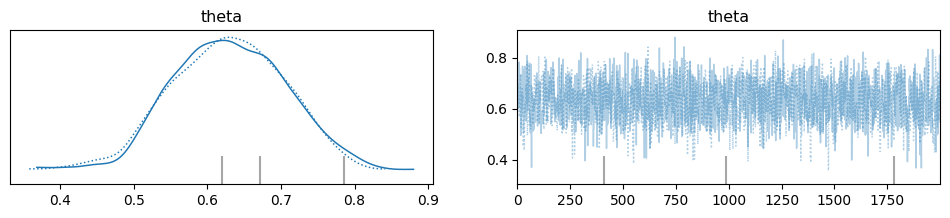

In [5]:
n = 30
k = 19

with pm.Model() as modelo_lineal:
    # prior
    theta1 = pm.Uniform.dist(0, 0.5)
    theta2 = pm.Uniform.dist(0.5, 1)
    pesos = [0.3, 0.7]
    theta = pm.Mixture('theta', w=pesos, comp_dists=[theta1, theta2])
    # likelihood binomial
    likelihood = pm.Binomial('likelihood', n=n, p=theta, observed=k)
    # posterior
    trace = pm.sample(2000)

az.plot_trace(trace)
plt.show()

<Axes: title={'center': 'theta'}>

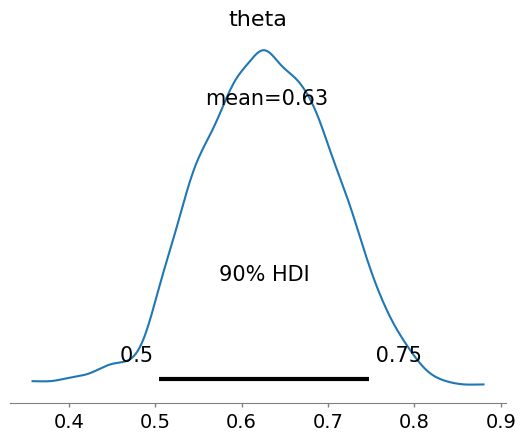

In [6]:
az.plot_posterior(trace, hdi_prob=0.90)

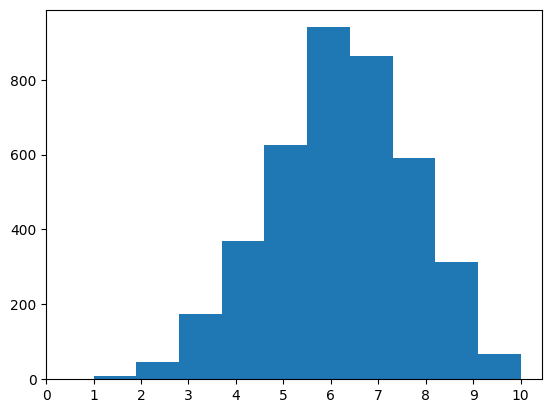

In [7]:
experimentos = 10

theta_samples = trace.posterior['theta'].values.flatten()

y_pred = np.random.binomial(experimentos, theta_samples, size=len(theta_samples))

plt.hist(y_pred)
plt.xticks(range(0, 11))
plt.show()

In [8]:
# proba por cada k
k_vals = np.arange(0, experimentos+1)
posterior_pred_probas = np.array([(y_pred == k).mean() for k in k_vals])
for k, proba in zip(k_vals, posterior_pred_probas):
    print(f"Probabilidad de {k} éxitos: {proba}")

Probabilidad de 0 éxitos: 0.0
Probabilidad de 1 éxitos: 0.0025
Probabilidad de 2 éxitos: 0.01125
Probabilidad de 3 éxitos: 0.0435
Probabilidad de 4 éxitos: 0.0925
Probabilidad de 5 éxitos: 0.1565
Probabilidad de 6 éxitos: 0.235
Probabilidad de 7 éxitos: 0.21575
Probabilidad de 8 éxitos: 0.148
Probabilidad de 9 éxitos: 0.07825
Probabilidad de 10 éxitos: 0.01675


Da lo mismo que antes, algo debe estar mal...  
Viendo la practica anterior, no habia mucha diferencia.

# 3)
Una muestra de estudiantes es medida en altura cada año durante 3 años. Después del tercer
año, se quiere ajustar una regresión lineal bayesiana para predecir la altura usando el año como
predictor. Escribor la definición matemática para esta regresión, justificando la elección de priors

In [9]:
# altura(año) = intercept + slope * año
# deberia considerar el error e ~ N(0, sigma) ??

# prior de intercept: N(100, 5)
# prior de slope: N(0, 10)

## a)
Supongamos que cada estudiante creció cada año. ¿Es necesario cambiar la elección de
priors?

In [10]:
# prior de slope: N(10, 3)

## b)
Supongaomos que la varianza entre las alturas de los estudiantes de la misma edad nunca es
más de 64 cm. ¿Lleva esto a revisar los priors?

In [11]:
# ??

# 4)
Generar datos sintéticos de una regresión lineal simple con ruido gaussiano, como los que generábamos cuando veíamos regresión lineal frecuentista.  
Por ejemplo, considerar la función  
 $f: R \rightarrow R$ dada por $f(x) = 2x -1, X \sim U(0,1), Y = f(X)$ y $n = 100$; tomar muestras $x_1,...., x_n$ de $X$ y aplicar la función $f$ a cada muestra para calcular $y_i = f(x_i)$, con $1 ≤ i ≤ n$.


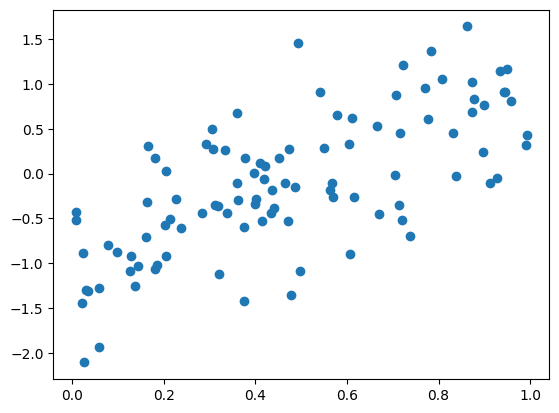

In [45]:
n = 100
X = np.random.uniform(0, 1, n)
Z = np.random.normal(0,np.sqrt(0.25), n)

Y = 2*X - 1 + Z
plt.plot(X, Y, 'o')


## a)
Ajustar un modelo lineal de la forma $y \sim N(\beta_0 + \beta_1x, \epsilon)$ usando PyMC. Graficar y describir
las posterior de los parámetros de la regresión.

c:\Users\nazar\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytensor\tensor\rewriting\elemwise.py:1030: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
c:\Users\nazar\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytensor\tensor\rewriting\elemwise.py:1030: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [beta0, beta1, epsilon]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 100 seconds.


array([[<Axes: title={'center': 'beta0'}>,
        <Axes: title={'center': 'beta0'}>],
       [<Axes: title={'center': 'beta1'}>,
        <Axes: title={'center': 'beta1'}>],
       [<Axes: title={'center': 'epsilon'}>,
        <Axes: title={'center': 'epsilon'}>]], dtype=object)

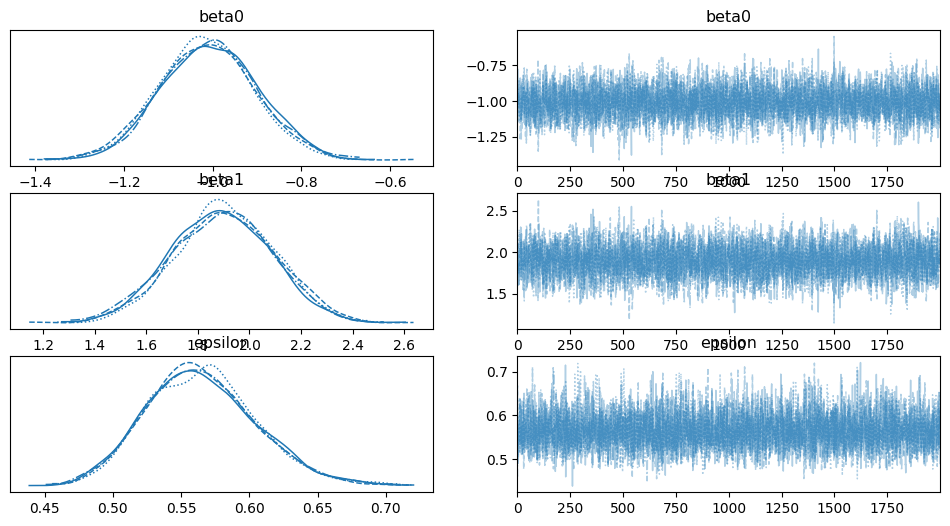

In [46]:
with pm.Model() as modelo_lineal:
    beta0 = pm.Uniform('beta0', -2, 2)
    beta1 = pm.Uniform('beta1', 1, 3)
    epsilon = pm.HalfNormal('epsilon', 1)
    y = pm.Normal('y', mu=beta0 + beta1*X, sigma=epsilon, observed=Y)
    trace = pm.sample(2000, chains = 4)

az.plot_trace(trace)

array([<Axes: title={'center': 'beta0'}>,
       <Axes: title={'center': 'beta1'}>,
       <Axes: title={'center': 'epsilon'}>], dtype=object)

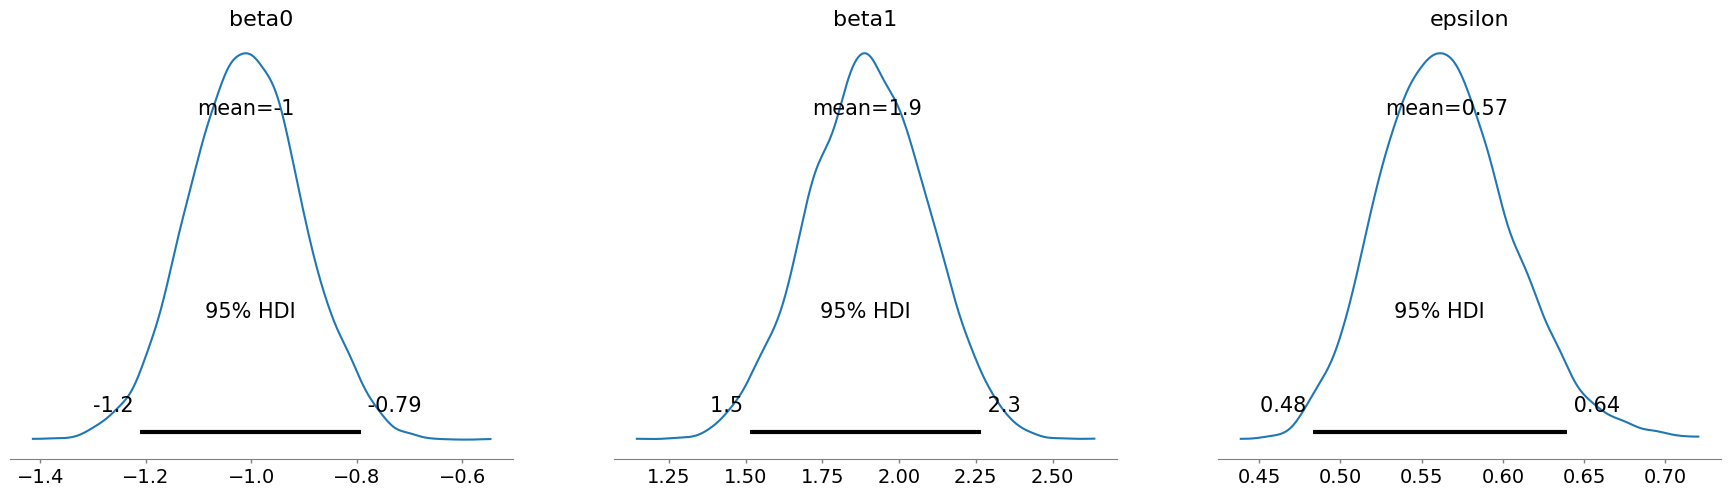

In [47]:
az.plot_posterior(trace, hdi_prob=0.95)

## b)
¿Cuál es el valor que estimamos que tenga $f(\frac{1}{2})$ ? ¿Con qué error?

In [55]:
betas_0 = trace.posterior['beta0'].values.flatten()
betas_1 = trace.posterior['beta1'].values.flatten()
epsilons = trace.posterior['epsilon'].values.flatten()

# Posterior predictive
x = 1/2
iters = 1_000
Ys = np.zeros(iters)
for _ in range(iters):
    index = np.random.choice(range(len(betas_0)))
    beta0 = betas_0[index]
    beta1 = betas_1[index]
    mu = beta0 + beta1 * x
    epsilon = epsilons[index]
    Ys[_] = stats.norm.rvs(loc=mu, scale=epsilon)

print(f"Media de las predicciones: {Ys.mean()}")

Media de las predicciones: -0.09178785305440405


## c)
Graficar y dar percentiles de la distribución de $\beta_0 + \frac{1}{2}\beta_1$.

Text(0.5, 1.0, 'y para x = 1/2')

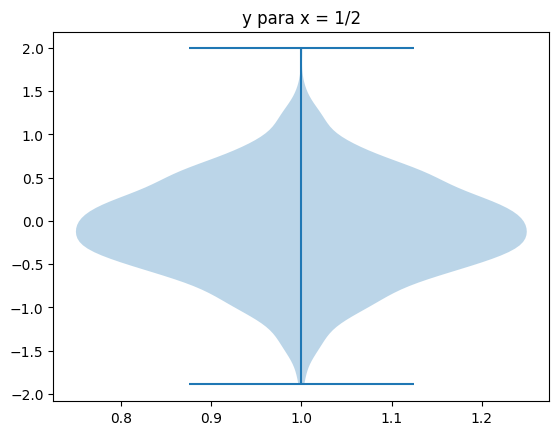

In [56]:
plt.violinplot(Ys)
plt.title('y para x = 1/2')

In [57]:
percentiles = np.percentile(Ys, [5, 25, 50, 75, 95])
print(f"Percentiles: 5%={percentiles[0]:.4f}, 25%={percentiles[1]:.4f}, 50%={percentiles[2]:.4f}, 75%={percentiles[3]:.4f}, 95%={percentiles[4]:.4f}")

Percentiles: 5%=-1.0548, 25%=-0.4629, 50%=-0.0819, 75%=0.2799, 95%=0.8476


# 6)


In [58]:
df_trazas = trace.posterior.to_dataframe().reset_index()
df_trazas.head()

,chain,draw,beta0,beta1,epsilon
0,0,0,-0.962704,1.617460,0.496362
1,0,1,-0.779617,1.665720,0.503563
2,0,2,-0.775247,1.692010,0.504981
3,0,3,-0.841447,1.598081,0.512555
4,0,4,-0.899592,1.717845,0.490376


Text(0, 0.5, 'Y')

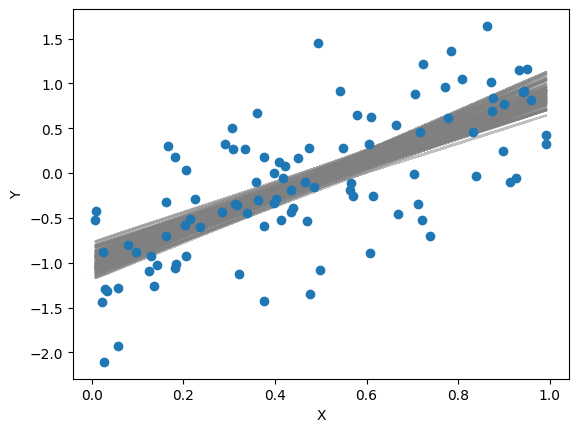

In [60]:
beta0_samples = df_trazas['beta0'].values.flatten()
beta1_samples = df_trazas['beta1'].values.flatten()

trazas = 100
_, ax = plt.subplots()

for i in range(trazas):
    mu = beta0_samples[i] + beta1_samples[i]*(X)
    ax.plot(X, mu, color='gray', alpha=0.5)
ax.plot(X, Y, 'o')
ax.set_xlabel('X')
ax.set_ylabel('Y')
    

In [61]:
iters = 1000
X_ordenado = np.sort(X)
Ys = np.zeros([iters, len(X_ordenado)])
for _ in range(iters):
    index = np.random.randint(len(beta0_samples))
    beta0 = beta0_samples[index]
    beta1 = beta1_samples[index]
    mu = beta0 + beta1 * X_ordenado
    epsilon = epsilons[index]
    Ys[_] = stats.norm.rvs(loc=mu, scale=epsilon)

C:\Users\nazar\AppData\Local\Temp\ipykernel_6400\4148134115.py:2: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdis = az.hdi(Ys, hdi_prob=0.90)


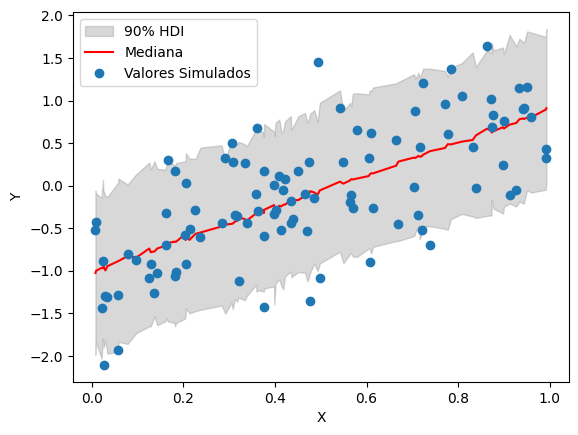

In [63]:
_, ax = plt.subplots()
hdis = az.hdi(Ys, hdi_prob=0.90)

ax.fill_between(X_ordenado, hdis[:,0], hdis[:,1], label = '90% HDI', color='gray', alpha=0.3)
ax.plot(X_ordenado, np.percentile(Ys, 50, axis=0), label='Mediana', color='red')
ax.plot(X, Y, 'o', label = "Valores Simulados")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.legend()

# 7)
Realizar un ajuste usando PyMC de un GLM de la práctica 3. Graficar la posterior de los parámetros. Graficar los datos y el HDI de la posterior predictive

## 6) practica 3
Se le propone a un grupo de niños y niñas una actividad: construir torres lo más altas posible usando bloques cúbicos y cilíndricos.   
Se registran en blocks.csv las edades de los infantes, el número de bloques y el tiempo empleado.  
En este problema, solo consideramos el número de bloques utilizados y las edades.


In [55]:
import pandas as pd
df = pd.read_csv('../datasets/blocks.csv', index_col=0)

In [9]:
df.head()

,Child,Number,Time,Trial,Shape,Age
0,A,11,30.0,1,Cube,4.67
1,B,9,19.0,1,Cube,5.00
2,C,8,18.6,1,Cube,4.42
3,D,9,23.0,1,Cube,4.33
4,E,10,29.0,1,Cube,4.33


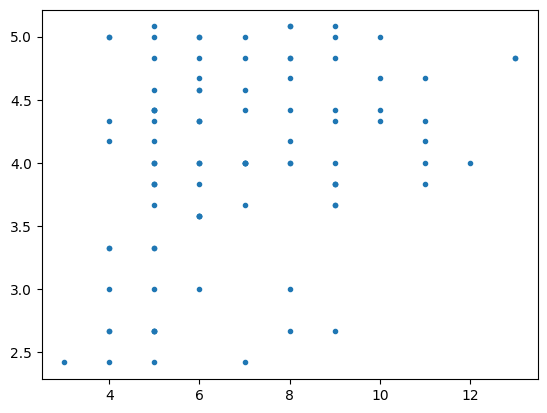

In [56]:
# graficar number vs age
plt.plot(df['Number'], df['Age'], '.')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [intercept, slope]


Output()

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 92 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


array([[<Axes: title={'center': 'intercept'}>,
        <Axes: title={'center': 'intercept'}>],
       [<Axes: title={'center': 'slope'}>,
        <Axes: title={'center': 'slope'}>]], dtype=object)

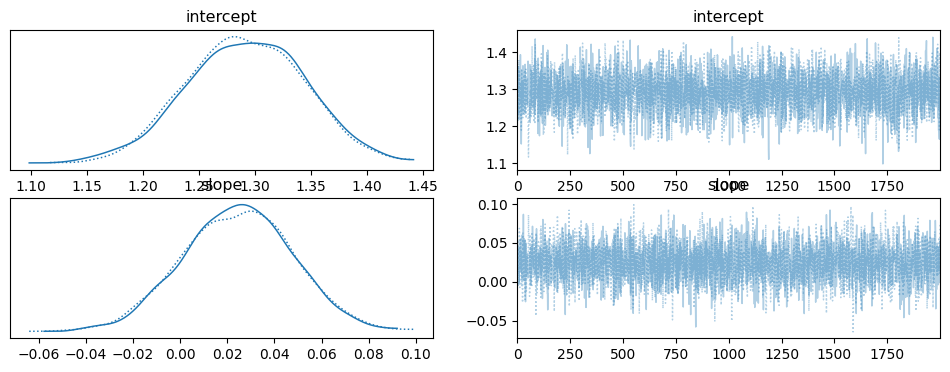

In [57]:
# ajustar glm
with pm.Model() as glm:
    # priors
    intercept = pm.Normal('intercept', df.Number.values.mean(), 2)
    slope = pm.Flat('slope')
    # funcion de link: log(mu) = intercept + slope * x
    mu = pm.math.exp(intercept + slope * (df.Number.values - df.Number.values.mean()))
    age = pm.Poisson('age', mu=mu, observed=df.Age)
    
    trace = pm.sample(2000)

az.plot_trace(trace)

array([<Axes: title={'center': 'intercept'}>,
       <Axes: title={'center': 'slope'}>], dtype=object)

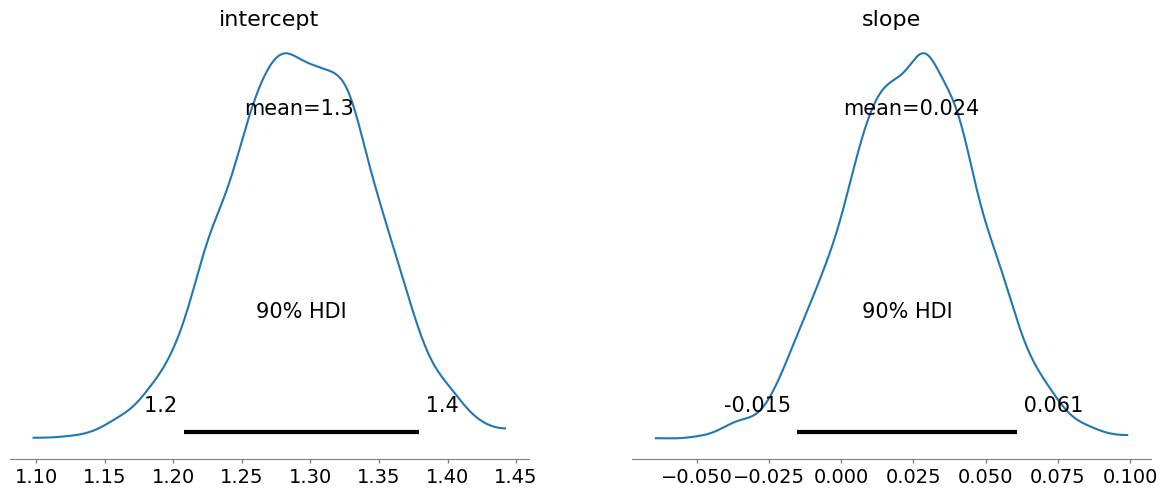

In [58]:
az.plot_posterior(trace, hdi_prob=0.90)

C:\Users\nazar\AppData\Local\Temp\ipykernel_4928\2633646539.py:15: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdis = az.hdi(ages, hdi_prob=0.90)


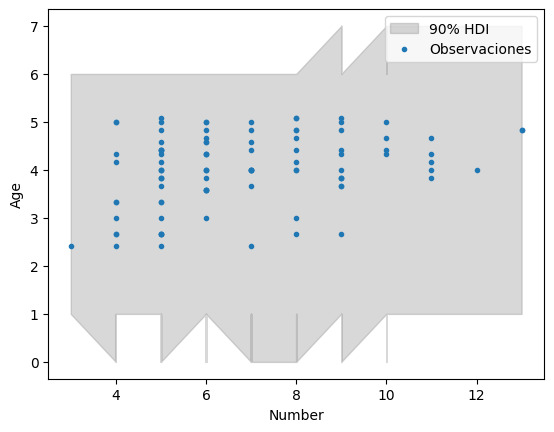

In [60]:
iters = 1_000
df_ordenado = df.sort_values(by='Number').reset_index(drop=True)
intercept_samples = trace.posterior['intercept'].values.flatten()
slope_samples = trace.posterior['slope'].values.flatten()

ages = np.zeros([iters, len(df_ordenado)])
for _ in range(iters):
    index = np.random.randint(len(intercept_samples))
    intercept = intercept_samples[index]
    slope = slope_samples[index]
    mu = np.exp(intercept + slope * (df_ordenado.Number.values - df_ordenado.Number.values.mean()))
    ages[_] = stats.poisson.rvs(mu)

_, ax = plt.subplots()
hdis = az.hdi(ages, hdi_prob=0.90)

ax.fill_between(df_ordenado.Number.values, hdis[:,0], hdis[:,1], label = '90% HDI', color='gray', alpha=0.3)
ax.plot(df_ordenado.Number, df_ordenado.Age, '.', label = "Observaciones")
ax.set_xlabel('Number')
ax.set_ylabel('Age')
ax.legend()

???????

Supongo que hay pocos datos y por eso queda asi.

## 7) practica 3
Nambe Mills en una fábrica de vajilla. En nambeware.csv figuran, entre otros datos, el diámetro y el precio de la vajilla
producida durante un período de tiempo fijo.

In [41]:
df = pd.read_csv('../datasets/nambeware.csv', index_col=0)
df.head()


,Type,Diam,Time,Price
0,CassDish,10.7,47.65,144.0
1,CassDish,14.0,63.13,215.0
2,CassDish,9.0,58.76,105.0
3,Bowl,8.0,34.88,69.0
4,Dish,10.0,55.53,134.0


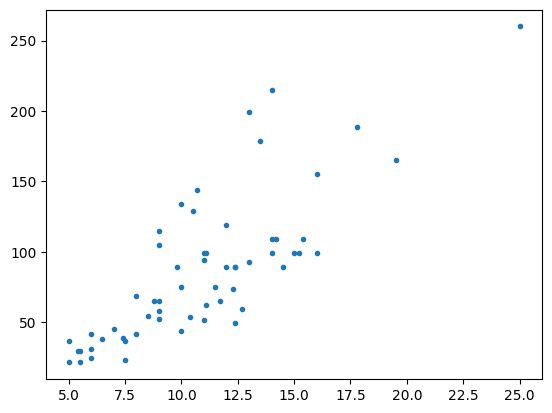

In [42]:
plt.plot(df['Diam'], df['Price'], '.')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [intercept, slope]


Output()

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 127 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


array([[<Axes: title={'center': 'intercept'}>,
        <Axes: title={'center': 'intercept'}>],
       [<Axes: title={'center': 'slope'}>,
        <Axes: title={'center': 'slope'}>]], dtype=object)

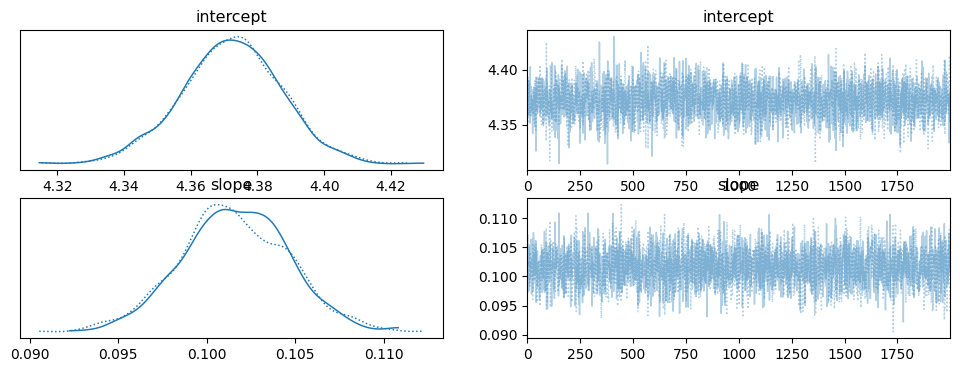

In [50]:
# ajustar glm
with pm.Model() as glm:
    # priors
    intercept = pm.Normal('intercept', df.Diam.values.mean(), 3)
    slope = pm.Flat('slope')
    # funcion de link: log(mu) = intercept + slope * x
    mu = pm.math.exp(intercept + slope * (df.Diam.values - df.Diam.mean()))
    price = pm.Poisson('price', mu=mu, observed=df.Price.values)
    
    trace = pm.sample(2000)

az.plot_trace(trace)

array([<Axes: title={'center': 'intercept'}>,
       <Axes: title={'center': 'slope'}>], dtype=object)

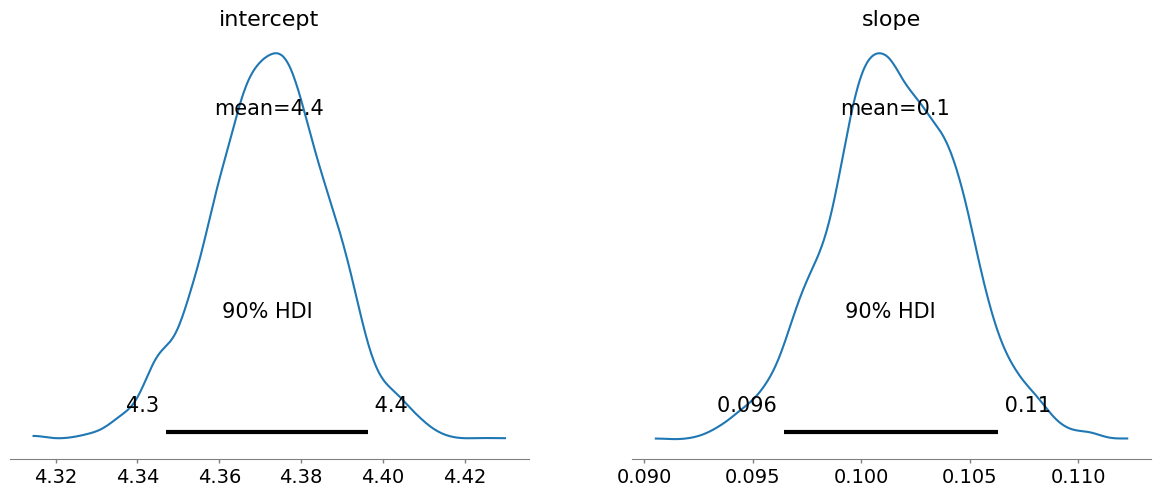

In [51]:
az.plot_posterior(trace, hdi_prob=0.90)

C:\Users\nazar\AppData\Local\Temp\ipykernel_4928\963037358.py:15: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdis = az.hdi(prices, hdi_prob=0.90)


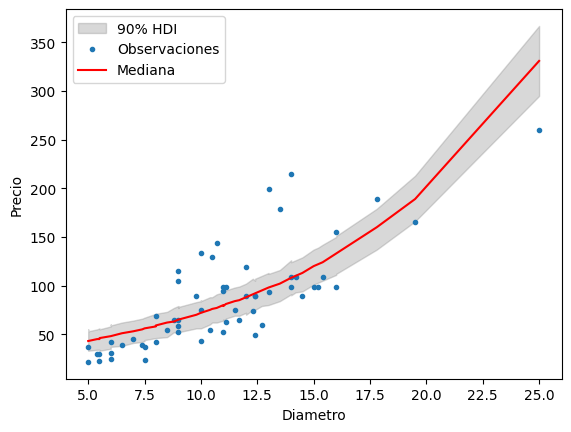

In [54]:
iters = 1_000
df_ordenado = df.sort_values(by='Diam').reset_index(drop=True)
intercept_samples = trace.posterior['intercept'].values.flatten()
slope_samples = trace.posterior['slope'].values.flatten()

prices = np.zeros([iters, len(df_ordenado)])
for _ in range(iters):
    index = np.random.randint(len(intercept_samples))
    intercept = intercept_samples[index]
    slope = slope_samples[index]
    mu = np.exp(intercept + slope * (df_ordenado.Diam.values - df_ordenado.Diam.mean()))
    prices[_] = stats.poisson.rvs(mu)

_, ax = plt.subplots()
hdis = az.hdi(prices, hdi_prob=0.90)

ax.fill_between(df_ordenado.Diam.values, hdis[:,0], hdis[:,1], label = '90% HDI', color='gray', alpha=0.3)
ax.plot(df_ordenado.Diam, df_ordenado.Price, '.', label = "Observaciones")
ax.plot(df_ordenado.Diam, np.percentile(prices, 50, axis=0), label='Mediana', color='red')
ax.set_xlabel('Diametro')
ax.set_ylabel('Precio')
ax.legend()

### con link: mu = inter + slope *x

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
c:\Users\nazar\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytensor\scalar\basic.py:2930: RuntimeWarning: invalid value encountered in log
  return np.log(x)
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [intercept, slope]


Output()

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 78 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


array([[<Axes: title={'center': 'intercept'}>,
        <Axes: title={'center': 'intercept'}>],
       [<Axes: title={'center': 'slope'}>,
        <Axes: title={'center': 'slope'}>]], dtype=object)

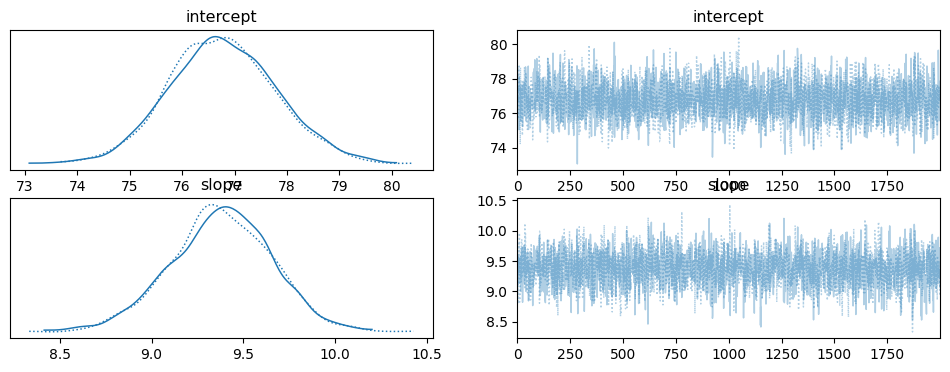

In [61]:
df = pd.read_csv('../datasets/nambeware.csv', index_col=0)
# ajustar glm
with pm.Model() as glm:
    # priors
    intercept = pm.Normal('intercept', df.Diam.values.mean(), 3)
    slope = pm.Flat('slope')
    # funcion de link: mu = intercept + slope * x
    mu = intercept + slope * (df.Diam.values - df.Diam.mean())
    price = pm.Poisson('price', mu=mu, observed=df.Price.values)
    
    trace = pm.sample(2000)

az.plot_trace(trace)

array([<Axes: title={'center': 'intercept'}>,
       <Axes: title={'center': 'slope'}>], dtype=object)

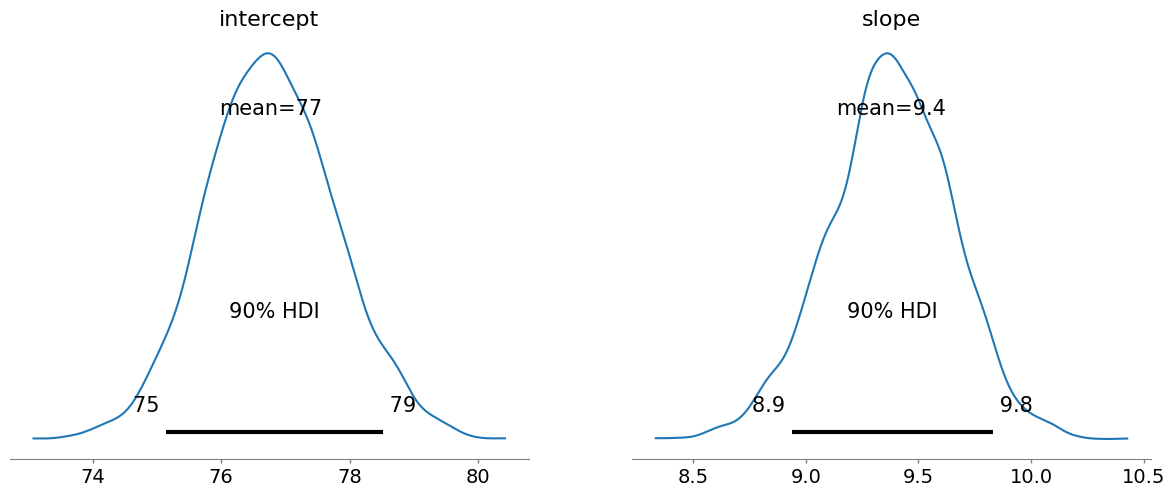

In [62]:
az.plot_posterior(trace, hdi_prob=0.90)

C:\Users\nazar\AppData\Local\Temp\ipykernel_4928\2935740181.py:15: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdis = az.hdi(prices, hdi_prob=0.90)


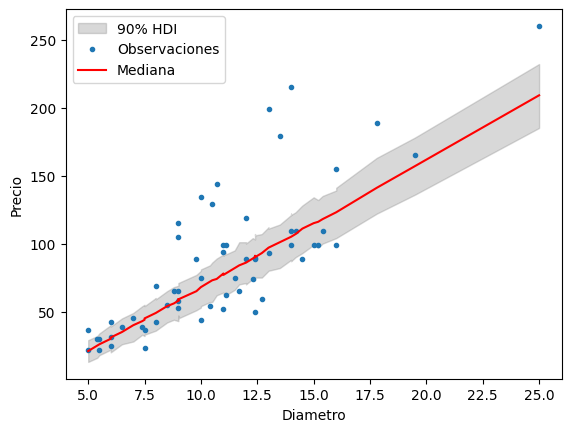

In [64]:
iters = 1_000
df_ordenado = df.sort_values(by='Diam').reset_index(drop=True)
intercept_samples = trace.posterior['intercept'].values.flatten()
slope_samples = trace.posterior['slope'].values.flatten()

prices = np.zeros([iters, len(df_ordenado)])
for _ in range(iters):
    index = np.random.randint(len(intercept_samples))
    intercept = intercept_samples[index]
    slope = slope_samples[index]
    mu = intercept + slope * (df_ordenado.Diam.values - df_ordenado.Diam.mean())
    prices[_] = stats.poisson.rvs(mu)

_, ax = plt.subplots()
hdis = az.hdi(prices, hdi_prob=0.90)

ax.fill_between(df_ordenado.Diam.values, hdis[:,0], hdis[:,1], label = '90% HDI', color='gray', alpha=0.3)
ax.plot(df_ordenado.Diam, df_ordenado.Price, '.', label = "Observaciones")
ax.plot(df_ordenado.Diam, np.percentile(prices, 50, axis=0), label='Mediana', color='red')
ax.set_xlabel('Diametro')
ax.set_ylabel('Precio')
ax.legend()